# initialize the workspace

## import relevant packages

In [1]:
# import packages
import numpy as np
import cv2
from skimage.measure import label, regionprops
from skimage import img_as_ubyte
import tifffile
import matplotlib.pyplot as plt

## import the test image
+ display it

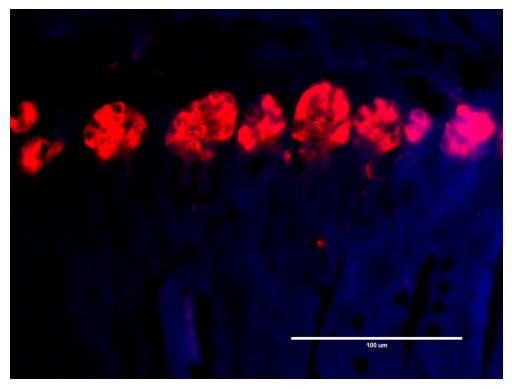

In [2]:
# class
class BlobDetector:
    def __init__(self, image_path):
        self.image_path = image_path
        self.raw_image = tifffile.imread(image_path)
        self.current_image = self.raw_image.copy()
        self.bar_mask = None
        self.binary_mask = None
        self.cleaned_mask = None
        self.blob_props = None
    def display(self):
        plt.imshow(self.current_image, cmap='gray')
        plt.axis('off')
        plt.show()
# init class
image_path = "DemoData/G2-ABX/G2-ABX/G2EB-RFP 40x-4.tif"
detector = BlobDetector(image_path)
detector.display()


# image preparation and processing

## prep class

In [3]:
class image_prep:
    class inconvenient_object_remover:
        def __init__(self, raw_image):
            self.raw_image = raw_image
        def remove_scale_bar(self, intensity_threshold=240, min_area=500, aspect_ratio_thresh=4.0):
            img = self.raw_image
            if img.ndim == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            else:
                gray = img.copy()
    
            _, binary = cv2.threshold(gray, intensity_threshold, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
            mask = np.ones_like(gray, dtype=np.uint8)
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                area = cv2.contourArea(cnt)
                aspect_ratio = max(w / h, h / w)
                if area > min_area and aspect_ratio > aspect_ratio_thresh:
                    cv2.rectangle(mask, (x, y), (x + w, y + h), 0, -1)
    
            self.bar_mask = mask
            if img.ndim == 3:
                self.current_image = cv2.merge([
                    cv2.bitwise_and(img[:, :, c], img[:, :, c], mask=mask)
                    for c in range(img.shape[2])
                ])
            else:
                self.current_image = cv2.bitwise_and(img, img, mask=mask)
            return self.current_image
    class select_image_channels:
        @staticmethod
        def red(img):
            
            if img.ndim == 3:
                current_image = img[:, :, 0]
            else:
                current_image = img.copy()
            return current_image
    class enhance_contrast:
        @staticmethod
        def CLAHE(img, clip_limit=2.0, tile_grid_size=(8,8)):
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
            img_8bit = img_as_ubyte(img / img.max())  # Normalize to 8-bit
            return clahe.apply(img_8bit)
    class masker:            
        def __init__(self, image):
            self.current_image = image
        def otsu(self):
            _, binary = cv2.threshold(self.current_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            self.binary_mask = binary
            return self
        def morph_cleanup(self, kernel_size=5):
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
            cleaned = cv2.morphologyEx(self.binary_mask, cv2.MORPH_OPEN, kernel)
            cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
            self.cleaned_mask = cleaned
            return self
        
            
    

## remove scale bar

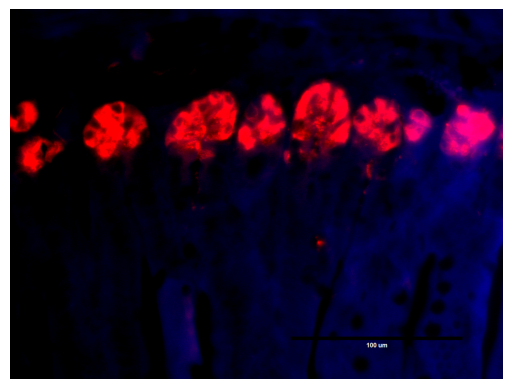

In [4]:
inconvenient_object_remover = image_prep.inconvenient_object_remover
detector.current_image = inconvenient_object_remover(detector.current_image).remove_scale_bar()
detector.display()

## select red chanel
this is bc the lysozyme stains fit nicely within the red channel, also removes the blue background

In [5]:
detector.current_image = image_prep.select_image_channels.red(detector.current_image)

## apply CLAHE
CLAHE stands for Contrast Limited Adaptive Histogram Equalization.

Let’s break that down:

Histogram Equalization is a method for adjusting image contrast by redistributing pixel intensities so they use the full available dynamic range (from black to white). It’s like stretching the histogram to make dark regions darker and bright regions brighter.

Adaptive means that instead of applying the same adjustment everywhere, CLAHE works in small regions of the image (called tiles or grid cells). This is important for images where brightness and contrast vary across different parts.

Contrast Limited means it avoids making the contrast too extreme in areas where the histogram is very concentrated (like in noisy regions). Without this, adaptive methods can produce weird artifacts like bright spots or speckles.

🎯 Why Do We Need CLAHE in the Code?
Your images (e.g., red channel from a tissue stain) might have:

Uneven lighting.

Varying contrast across different regions.

Faint signals in some areas that you want to enhance.

Simply applying a global contrast adjustment (like cv2.equalizeHist) might:

Overexpose bright regions.

Leave dark regions unchanged.

CLAHE helps by:
✅ Boosting contrast locally within each tile.
✅ Preserving details in both bright and dark regions.
✅ Reducing the risk of amplifying noise in homogeneous areas.

This makes it easier to detect blobs (your regions of interest) by:

Enhancing the signal where the stain is faint.

Making sure contrast is improved everywhere, not just globally.

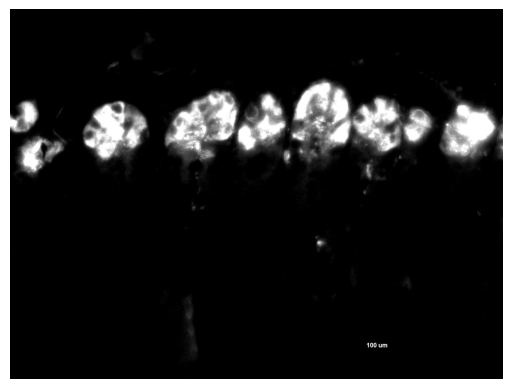

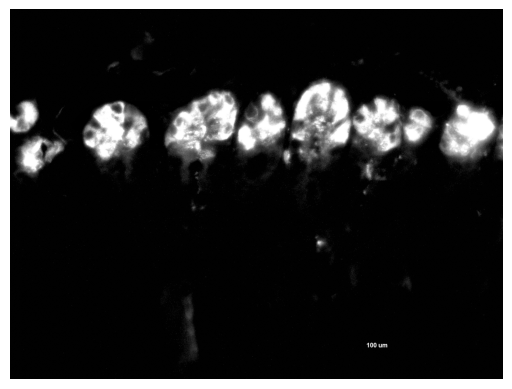

In [6]:
detector.display()
detector.current_image = image_prep.enhance_contrast.CLAHE(detector.current_image)
detector.display()
    

## binary mask
the goal of this is to create a binary mask that cleanly captures the boundries of the stained lysozyme regions

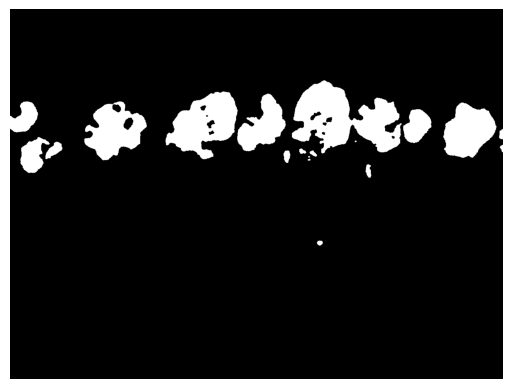

In [7]:
detector.binary_mask = image_prep.masker(detector.current_image).otsu().morph_cleanup().cleaned_mask
plt.imshow(detector.binary_mask, cmap='gray')  # mask is your binary image
plt.axis('off')  # Optional: hide axis
plt.show()
